In [1]:
import numpy as np
import pandas as pd
import re
import difflib
import seaborn as sns
import math
import matplotlib.pyplot as plt 
%matplotlib inline
from math import factorial

In [3]:
!pwd

/Users/jaichitra.balakrishnan/galvanizeu/DSCI6002-student/Project


**Read Data**

In [2]:
menu     = pd.read_csv("data/whats-on-the-menu/Menu.csv")

In [5]:
menuitem = pd.read_csv("data/whats-on-the-menu/MenuItem.csv")

In [6]:
menupage = pd.read_csv("data/whats-on-the-menu/MenuPage.csv")

In [7]:
dish     = pd.read_csv("data/whats-on-the-menu/Dish.csv")

**Data Health Check and Prepare Clean Data Set for Analysis**

In [8]:
# Overview menu
print(menu.shape)
print(menu.columns)
menu.head(n=5)

(17545, 20)
Index(['id', 'name', 'sponsor', 'event', 'venue', 'place',
       'physical_description', 'occasion', 'notes', 'call_number', 'keywords',
       'language', 'date', 'location', 'location_type', 'currency',
       'currency_symbol', 'status', 'page_count', 'dish_count'],
      dtype='object')


,id,name,sponsor,event,venue,place,physical_description,occasion,notes,call_number,keywords,language,date,location,location_type,currency,currency_symbol,status,page_count,dish_count
0,12463,NaN,HOTEL EASTMAN,BREAKFAST,COMMERCIAL,"HOT SPRINGS, AR",CARD; 4.75X7.5;,EASTER;,NaN,1900-2822,NaN,NaN,1900-04-15,Hotel Eastman,NaN,NaN,NaN,complete,2,67
1,12464,NaN,REPUBLICAN HOUSE,[DINNER],COMMERCIAL,"MILWAUKEE, [WI];",CARD; ILLUS; COL; 7.0X9.0;,EASTER;,WEDGEWOOD BLUE CARD; WHITE EMBOSSED GREEK KEY ...,1900-2825,NaN,NaN,1900-04-15,Republican House,NaN,NaN,NaN,complete,2,34
2,12465,NaN,NORDDEUTSCHER LLOYD BREMEN,FRUHSTUCK/BREAKFAST;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,CARD; ILLU; COL; 5.5X8.0;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, STEAMSHIP A...",1900-2827,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,2,84
3,12466,NaN,NORDDEUTSCHER LLOYD BREMEN,LUNCH;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,CARD; ILLU; COL; 5.5X8.0;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, HARBOR SCEN...",1900-2828,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,2,63
4,12467,NaN,NORDDEUTSCHER LLOYD BREMEN,DINNER;,COMMERCIAL,DAMPFER KAISER WILHELM DER GROSSE;,FOLDER; ILLU; COL; 5.5X7.5;,NaN,"MENU IN GERMAN AND ENGLISH; ILLUS, HARBOR SCEN...",1900-2829,NaN,NaN,1900-04-16,Norddeutscher Lloyd Bremen,NaN,NaN,NaN,complete,4,33


In [9]:
# Check if id can be used as unique identifier in menu
print(menu['id'].isnull().sum(), menu.duplicated(['id']).sum())

0 0


In [10]:
# Check which of name, sponsor, place, location are 'cleaner' to describe location of menu
print("Name nulls     - ", menu.name.isnull().sum())
print("Sponsor nulls  - ", menu.sponsor.isnull().sum())
print("Place nulls    - ", menu.place.isnull().sum())
print("Location nulls - ", menu.location.isnull().sum())

Name nulls     -  14348
Sponsor nulls  -  1561
Place nulls    -  9422
Location nulls -  0


In [3]:
# Copy relevant fields to new df
mdf = menu[['id', 'event', 'venue', 'occasion', 'date', 'location', 'status', 'dish_count']]

In [4]:
# Split date to year, month and day columns
# Avoid loc warning about writes making it back to the original frame 
pd.options.mode.chained_assignment = None
mdf['year'], mdf['month'], mdf['day'] = mdf['date'].str.split('-', 2).str

In [5]:
# Make to string, lower case and remove special characters
mdf = mdf.apply(lambda x: x.astype(str).str.lower())
mdf = mdf.apply(lambda x: x.replace('[^A-Za-z0-9]',' ',regex=True))
mdf = mdf.apply(lambda x: x.str.strip())
del mdf['date']

In [6]:
# Find max and min values for year
print("Year  -", sorted(mdf.year.unique())[0:5], sorted(mdf.year.unique())[-5:])
print("Month -", sorted(mdf.month.unique())[0:5], sorted(mdf.month.unique())[-5:])
print("Day   -", sorted(mdf.day.unique())[0:5], sorted(mdf.day.unique())[-5:])

Year  - ['0001', '0190', '1091', '1851', '1852'] ['2008', '2012', '2015', '2928', 'nan']
Month - ['01', '02', '03', '04', '05'] ['09', '10', '11', '12', 'nan']
Day   - ['01', '02', '03', '04', '05'] ['28', '29', '30', '31', 'nan']


In [7]:
# Find if dates are relatable and find count to decided if observations can be dropped
print("Year nulls  - ", len(mdf[mdf.year=='nan']))
print("Month nulls - ", len(mdf[mdf.month=='nan']))
print("Day nulls   - ", len(mdf[mdf.day=='nan']))

Year nulls  -  586
Month nulls -  586
Day nulls   -  586


In [8]:
mdf[((mdf['year'] < '1800') & (mdf['year'] > '2017'))].shape

(0, 10)

In [9]:
# Hardly any records to affect if incorrect guess
mdf.loc[mdf['year'] =='0190', 'year'] = '1990'
mdf.loc[mdf['year'] =='1091', 'year'] = '1991'
mdf.loc[mdf['year'] =='2928', 'year'] = '1928'
mdf.loc[mdf['year'] =='0001', 'year'] = '2001'

In [10]:
mdf[((mdf['year'] > '1800') & (mdf['year'] <= '2017')) & \
          ((mdf['month'] >= '01') & (mdf['month'] <= '12')) & \
          ((mdf['day'] >= '01') & (mdf['day'] <= '31')) ].shape

(16959, 10)

In [11]:
# Leave out the records with null values. Enough data to work with
mdf = mdf[((mdf['year'] > '1800') & (mdf['year'] <= '2017')) & \
          ((mdf['month'] >= '01') & (mdf['month'] <= '12')) & \
          ((mdf['day'] >= '01') & (mdf['day'] <= '31')) ]

In [12]:
mdf["id"] = mdf.id.apply(int)
mdf["dish_count"] = mdf.dish_count.apply(int)
mdf["year"] = mdf.year.apply(int)
mdf["month"] = mdf.month.apply(int)
mdf["day"] = mdf.day.apply(int)

In [13]:
# See if the Status categorical feature has limited values
print('Unique Status Values   # -',len(mdf.status.unique()))
print('Unique Status Values     -',mdf.status.unique())

Unique Status Values   # - 2
Unique Status Values     - ['complete' 'under review']


In [16]:
# See if the Event categorical feature has limited values
print('Unique Event Values   # -',len(mdf.event.unique()))
print('Unique Event Values     -',mdf.event.unique()[0:50])

Unique Event Values   # - 1649
Unique Event Values     - ['breakfast' 'dinner' 'fruhstuck breakfast' 'lunch' 'supper'
 'cafe luncheon' 'annual banquet' 'dinne' 'nan' 'luncheon' 'carte du jour'
 'annual meeting' 'banquet of the fifty ninth annual convention'
 'fifth annual reunion' 'shakepeare commemoration'
 '26th anniversary banquet' 'twenty ninth annual dinner' 'sunday dinner'
 'second annual dinner' 'seventh annual dinner' 'lunch   dinner'
 'annual dinner'
 'complimentary banquet given by the city government of boston to the boards of trade of the western cities'
 'fest bankett' 'daily menu' 'daily menu   11 30 to 3 00'
 'dinner to the board of officers of the catholic club of the city of new york'
 'annual outing of edward thompson co' 'banquet' 'menu'
 'semi annual dinner' 'souper' '11th annual banquet'
 'daily menu   11 30 t0 3 00' 'a la carte menu' 'tiffin' 'annual outing'
 'evening dinner' 'dinner in honor of h i m mutsu hito 47th birthday'
 'evening meal' 'daily' 'bill of fare

In [15]:
mdf.head(n=10)

,id,event,venue,occasion,location,status,dish_count,year,month,day
0,12463,breakfast,commercial,easter,hotel eastman,complete,67,1900,4,15
1,12464,dinner,commercial,easter,republican house,complete,34,1900,4,15
2,12465,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,84,1900,4,16
3,12466,lunch,commercial,nan,norddeutscher lloyd bremen,complete,63,1900,4,16
4,12467,dinner,commercial,nan,norddeutscher lloyd bremen,complete,33,1900,4,16
5,12468,dinner,commercial,nan,canadian pacific railway company,complete,37,1900,4,16
6,12469,supper,commercial,nan,hotel netherland,complete,144,1900,4,16
7,12470,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,80,1900,4,17
8,12471,lunch,commercial,nan,norddeutscher lloyd bremen,complete,67,1900,4,17
9,12472,dinner,commercial,nan,norddeutscher lloyd bremen,complete,29,1900,4,17


In [32]:
mdf.head(n=20)

,id,event,venue,occasion,location,status,dish_count,year,month,day,eventt
0,12463,breakfast,commercial,easter,hotel eastman,complete,67,1900,4,15,breakfast
1,12464,dinner,commercial,easter,republican house,complete,34,1900,4,15,dinner
2,12465,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,84,1900,4,16,breakfast
3,12466,lunch,commercial,nan,norddeutscher lloyd bremen,complete,63,1900,4,16,lunch
4,12467,dinner,commercial,nan,norddeutscher lloyd bremen,complete,33,1900,4,16,dinner
5,12468,dinner,commercial,nan,canadian pacific railway company,complete,37,1900,4,16,dinner
6,12469,supper,commercial,nan,hotel netherland,complete,144,1900,4,16,dinner
7,12470,fruhstuck breakfast,commercial,nan,norddeutscher lloyd bremen,complete,80,1900,4,17,breakfast
8,12471,lunch,commercial,nan,norddeutscher lloyd bremen,complete,67,1900,4,17,lunch
9,12472,dinner,commercial,nan,norddeutscher lloyd bremen,complete,29,1900,4,17,dinner


In [35]:
# Make approximate event type from event
# Check type of source field. As the object had both float and string elements
mdf.event.map(lambda x: type(x))
# Cast elements of the event object as str and make eventt
mdf['eventt'] = mdf.event.apply(str)

def set_eventt(lval):
    for idx in range(len(lval)):
        val = [x.replace("_"," ") for x in str.split(lval[idx],":")]
        # If close match found, then replace with last ordered, matched lval else miscellaneous
        mdf.eventt = mdf.eventt.apply(lambda txt: (val[len(val)-1]) \
                 if len(difflib.get_close_matches(val[len(val)-2], txt.split())) \
                 else txt)
        #mdf.loc[mdf['eventt'].str.contains(, case=False), 'eventt'] = val[len(val)-1]

#List of possible event values with search and replace string seperated by : if different
events = "lunch breakfast dinner morning:breakfast afternoon:lunch supper:dinner \
          menu annual:organized meeting:organized banquet:organized convention:organized \
          reunion:organized \
          christmas:holiday new_year:holiday patrick:holiday july:holiday \
          thanksgiving:holiday veterans:holiday day:holiday \
          anniversary:celebration birthday:celebration wedding:celebration".split()
set_eventt(events)
allowed_events=[x.split(':')[-1].replace("_"," ") for x in events]
mdf.loc[~mdf["eventt"].isin(allowed_events), "eventt"] = "miscellaneous"

In [25]:
# See if the approximated Eventt categorical feature has limited values
print('Unique Eventt Values   # -',len(mdf.eventt.unique()))
print('Unique Eventt Values     -',mdf.eventt.unique())

Unique Eventt Values   # - 8
Unique Eventt Values     - ['breakfast' 'dinner' 'lunch' 'organized' 'miscellaneous' 'menu' 'holiday'
 'celebration']


In [26]:
print('Unique Venue Values    # -',len(mdf.venue.unique()))
print('Unique Occasion Values # -',len(mdf.occasion.unique()))

Unique Venue Values    # - 141
Unique Occasion Values # - 320


In [27]:
type(mdf.year.map(lambda x: int(round(x/10,2)*10)))

pandas.core.series.Series

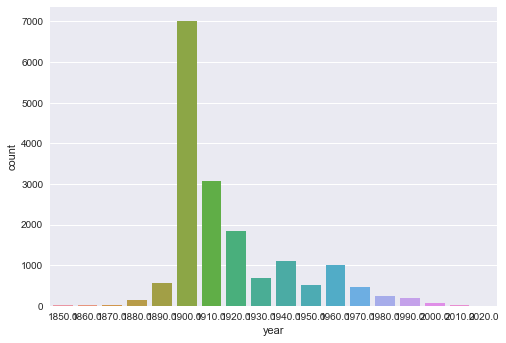

In [28]:
sns.set(style="darkgrid")
ax = sns.countplot(x=(round(mdf.year/10,0)*10), data=mdf)

The menus are from 1851 to 2017. However many of the menus are from the turn of the 20th century. Very few of the menus are from this century. This could be a reflection of a change in the food culture between 1900-1920. Or, it may just ne that modern menus are not yet fully included and represented in the data set

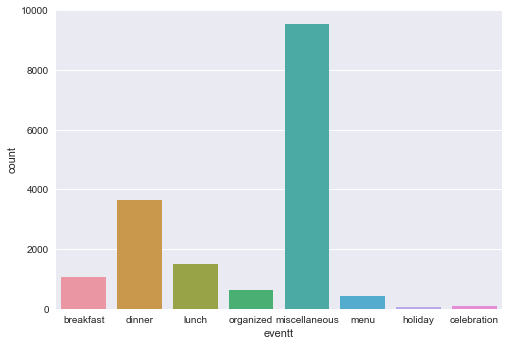

In [29]:
sns.set(style="darkgrid")
ax = sns.countplot(x=mdf.eventt, data=mdf)

In [30]:
pd.crosstab(mdf.eventt, mdf.status, margins=True)

status,complete,under review,All
eventt,,,
breakfast,1067,2,1069
celebration,81,0,81
dinner,3621,13,3634
holiday,68,0,68
lunch,1506,2,1508
menu,431,1,432
miscellaneous,9500,40,9540
organized,625,2,627
All,16899,60,16959


Crosstab of the menu status tells us most menus are complete and very few are under review in the system

In [31]:
sorted(mdf.venue.unique())
#mdf.loc[mdf["occasion"].isin(['gov','govt']), "eventt"] = "miscellaneous"

['',
 'aa',
 'airline',
 'alumni',
 'cam',
 'club',
 'cmmercial',
 'com',
 'com  pol',
 'com soc',
 'comm',
 'commercial',
 'commercoa',
 'conn',
 'cultural',
 'dom',
 'educ',
 'educ  prof',
 'educational',
 'edus',
 'foreign',
 'foreign  hotel',
 'foreign hotel',
 'foreign hotel restaurant',
 'foreign restaurant',
 'foreigneign',
 'fraternity',
 'gk',
 'gov',
 'gov t',
 'govt',
 'greek letter  fraternity or sorority',
 'hotel',
 'hotel  for',
 'hotel restaurant',
 'individual',
 'mil',
 'milit',
 'military',
 'musical',
 'nac',
 'nan',
 'nav',
 'naval',
 'other',
 'other   presumably british royal family',
 'other  appears to be a private luncheon party',
 'other  british royal family',
 'other  club',
 'other  expatriate',
 'other  group of citizens',
 'other  group of friends',
 'other  head of royal family',
 'other  hospital',
 'other  individual',
 'other  individually hosted party',
 'other  international cultural group',
 'other  literary assoc',
 'other  london club',
 'other 

In [32]:
mdf["occasion_type"] = mdf.venue
mdf.loc[mdf['occasion_type'].str.contains('other'), 'occasion_type']= 'other'
mdf.loc[mdf['occasion_type'].str.contains('airline'), 'occasion_type'] = 'airline'
mdf.loc[mdf['occasion_type'].str.contains('aa'), 'occasion_type'] = 'airline'
mdf.loc[mdf['occasion_type'].str.contains('cam'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('cmmercial'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('com'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('conn'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('club'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('dom'), 'occasion_type'] = 'commercial'
mdf.loc[mdf['occasion_type'].str.contains('edu'), 'occasion_type'] = 'educational'
mdf.loc[mdf['occasion_type'].str.contains('foreign'), 'occasion_type'] = 'foreign'
mdf.loc[mdf['occasion_type'].str.contains('fraternity'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('gk'), 'occasion_type'] = 'government'
mdf.loc[mdf['occasion_type'].str.contains('gov'), 'occasion_type'] = 'government'
mdf.loc[mdf['occasion_type'].str.contains('hotel'), 'occasion_type'] = 'restauarant'
mdf.loc[mdf['occasion_type'].str.contains('individual'), 'occasion_type'] = 'individual'
mdf.loc[mdf['occasion_type'].str.contains('mil'), 'occasion_type'] = 'military'
mdf.loc[mdf['occasion_type'].str.contains('nac'), 'occasion_type'] = 'military'
mdf.loc[mdf['occasion_type'].str.contains('nav'), 'occasion_type'] = 'military'
mdf.loc[mdf['occasion_type'].str.contains('museum'), 'occasion_type'] = 'entertainment'
mdf.loc[mdf['occasion_type'].str.contains('music'), 'occasion_type'] = 'entertainment'
mdf.loc[mdf['occasion_type'].str.contains('nan'), 'occasion_type'] = 'unknown'
mdf.loc[mdf['occasion_type'].str.contains('res'), 'occasion_type'] = 'restauarant'
mdf.loc[mdf['occasion_type'].str.contains('rel'), 'occasion_type'] = 'religious'
mdf.loc[mdf['occasion_type'].str.contains('soc'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('som'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('ss'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('pol'), 'occasion_type'] = 'political'
mdf.loc[mdf['occasion_type'].str.contains('pat'), 'occasion_type'] = 'patriotic'
mdf.loc[mdf['occasion_type'].str.contains('pri'), 'occasion_type'] = 'private'
mdf.loc[mdf['occasion_type'].str.contains('pro'), 'occasion_type'] = 'professional'
mdf.loc[mdf['occasion_type'].str.contains('reporters'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains('steamship'), 'occasion_type'] = 'social'
mdf.loc[mdf['occasion_type'].str.contains(''), 'occasion_type'] = 'unknown'
mdf.loc[mdf['occasion_type'].str.contains('nan'), 'occasion_type'] = 'unknown'



In [33]:
#def similar(a, b):
#    return SequenceMatcher(None, a, b).ratio()

In [34]:
mdf.to_csv("data/Menu_Cleanse.csv")